# Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

def load_and_split_data(directory, train_proportion=0.7, valid_proportion=0.66):  # valid_size adjusted for 70% train, 21% valid, 9% test
    all_files=[]
    for dirname,_,filenames in os.walk('../data/'):
        for filename in filenames:
            if filename.endswith('csv'):
                all_files.append(f'{dirname}/{filename}')
    all_files.sort()
    
    valve1_dat={file.split('/')[-1]:pd.read_csv(file,sep=';',index_col='datetime',parse_dates=True)
                  for file in all_files if 'valve1' in file}
    
    #concatenate data(order in time series by sort_index)
    valve1_data = pd.concat(list(valve1_dat.values()),axis=0).sort_index()
    
    train_pre_size = len(valve1_data)
    train_size = int(train_pre_size*train_proportion)
    train = valve1_data[0:train_size]
    y_train = valve1_data[0:train_size]['anomaly'].values
    x_train = valve1_data[0:train_size].drop(columns=['anomaly', 'changepoint'])
    
    valid_pre_size = train_pre_size - train_size
    valid_size = int(valid_pre_size*valid_proportion)
    valid = valve1_data[train_size:train_size + valid_size]
    y_valid = valve1_data[train_size:train_size + valid_size]['anomaly'].values
    x_valid = valve1_data[train_size:train_size + valid_size].drop(columns=['anomaly', 'changepoint'])
    
    test = valve1_data[train_size + valid_size:]
    y_test = valve1_data[train_size + valid_size:]['anomaly'].values
    x_test = valve1_data[train_size + valid_size:].drop(columns=['anomaly', 'changepoint'])

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_and_split_data('../data/')

In [4]:
display(x_train)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0000
2020-03-09 10:14:34,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0000
2020-03-09 10:14:35,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0000
2020-03-09 10:14:36,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0000
2020-03-09 10:14:37,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 13:59:09,0.028142,0.039445,0.981651,0.382638,66.9901,24.7381,232.774,32.0000
2020-03-09 13:59:10,0.028283,0.040615,0.966102,0.054711,66.8982,24.7404,227.030,32.0226
2020-03-09 13:59:11,0.028778,0.041955,0.827491,-0.601143,66.8706,24.7499,228.784,32.9781


In [77]:
x_train.index.min(), x_train.index.max()

(Timestamp('2020-03-09 10:14:33'), Timestamp('2020-03-09 13:59:13'))

In [78]:
x_train.index.max() - x_train.index.min()

Timedelta('0 days 03:44:40')

# Building Baseline Pipeline

In [5]:
from transformers.kaiser_window_smoother import KaiserWindowSmoother
from transformers.temporal_feature_creator import TemporalFeatureCreator
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.pipeline import Pipeline

In [7]:
LOOK_BACK=10
F_BETA = 0.5

In [8]:
pipeline = Pipeline([
    ('look_back', KaiserWindowSmoother()),
    ('scaler', StandardScaler()),
    ('classifier', TemporalFeatureCreator(LOOK_BACK))
])

In [9]:
train_x = pipeline.fit_transform(x_train)
valid_x = pipeline.transform(x_valid)
test_x = pipeline.transform(x_test)

In [10]:
display(test_x)

,A1_mean,A1_min,A1_max,A2_mean,A2_min,A2_max,Cur_mean,Cur_min,Cur_max,Pre_mean,...,Temp_max,Ther_mean,Ther_min,Ther_max,Vol_mean,Vol_min,Vol_max,Flow_mean,Flow_min,Flow_max
0,0.051600,-0.378375,0.574997,-1.361974,-2.128975,-0.809912,0.463603,0.207286,0.797031,0.248922,...,-1.005870,-1.765112,-1.767461,-1.762285,0.621834,-0.629836,1.626911,0.538125,0.384955,0.666354
1,-0.030184,-0.378375,0.496766,-1.512460,-2.314773,-0.855490,0.430880,0.207286,0.797031,-0.061313,...,-1.005870,-1.764840,-1.767414,-1.762285,0.390858,-0.717491,1.626911,0.509985,0.384955,0.659746
2,-0.094051,-0.378375,0.397665,-1.666669,-2.397577,-0.957886,0.394410,0.207286,0.660126,-0.317197,...,-1.005870,-1.764811,-1.767414,-1.762285,0.125208,-1.029592,1.251906,0.482653,0.384955,0.640552
3,-0.131753,-0.378375,0.267799,-1.809283,-2.397577,-1.086631,0.371160,0.207286,0.660126,-0.518191,...,-1.006089,-1.764895,-1.768248,-1.762285,-0.139896,-1.399126,0.990952,0.457446,0.384955,0.581710
4,-0.149154,-0.378375,0.093789,-1.937672,-2.397577,-1.237678,0.366910,0.207286,0.617621,-0.654661,...,-1.006089,-1.765119,-1.768621,-1.762285,-0.352253,-1.399126,0.850233,0.442999,0.384955,0.559987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,0.604958,0.538541,0.671134,0.422064,0.309524,0.571205,-1.431088,-1.756308,-0.761723,-0.104830,...,-1.111294,-1.979203,-1.984693,-1.969486,0.157707,-0.591353,0.727824,0.794597,0.688355,0.849990
1840,0.602093,0.538541,0.671134,0.414695,0.309524,0.571205,-1.507540,-1.756308,-0.975626,0.205674,...,-1.111294,-1.977590,-1.984693,-1.967955,0.250531,-0.452272,0.727824,0.782781,0.688355,0.843259
1841,0.593067,0.462452,0.671134,0.420802,0.309524,0.571205,-1.571616,-1.756308,-1.232279,0.425563,...,-1.111294,-1.975776,-1.983675,-1.966548,0.263585,-0.321732,0.727824,0.771986,0.688355,0.835189
1842,0.583487,0.442743,0.671134,0.411778,0.309524,0.546227,-1.606803,-1.756308,-1.409503,0.573982,...,-1.111294,-1.973831,-1.983038,-1.964224,0.217118,-0.515698,0.727824,0.760680,0.688355,0.826540


In [11]:
train_y = y_train[LOOK_BACK-1:]
valid_y=y_valid[LOOK_BACK-1:]
test_y=y_test[LOOK_BACK-1:]

# Baseline Training

In [12]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf

# fix random seed
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = "0"

#LightGBM train predict function
def lgb_train_predict(x_train, y_train, x_valid, y_valid, x_test, y_test, test_flag=False, beta=1):
    
    #fine-tunned hyper paramters as found in baseline
    lgb_params = {
        'objective':'binary',
        'metric':'binary_error',
        'force_row_wise':True,
        'seed':0,
        'learning_rate':0.0424127,
        'min_data_in_leaf':15,
        'max_depth':24,
        'num_leaves':29
    }
    
    lgb_train=lgb.Dataset(x_train,y_train)
    lgb_valid=lgb.Dataset(x_valid,y_valid)
    lgb_test=lgb.Dataset(x_test,y_test)
    
    model_lgb=lgb.train(params=lgb_params,train_set=lgb_train, \
                        valid_sets=[lgb_train,lgb_valid], \
                        verbose_eval=0,early_stopping_rounds=20)
    
    test_pred=np.zeros((len(y_test),1))
    test_pred[:,0]=np.where(model_lgb.predict(x_test)>=0.5,1,0)
    test_acc=accuracy_score(y_test.reshape(-1,1),test_pred)
    test_f1score=f1_score(y_test.reshape(-1,1),test_pred)
    test_cm=confusion_matrix(y_test.reshape(-1,1),test_pred)
    test_f_beta_score = fbeta_score(y_test.reshape(-1,1), test_pred, beta=beta)
        
    return test_acc, test_f1score, test_cm, test_pred, model_lgb, test_f_beta_score

In [13]:
test_acc,test_f1score,test_cm,test_pred,model_lgb, test_f_beta_score=lgb_train_predict(train_x,train_y,valid_x,valid_y,test_x,test_y,beta=2)

tn, fp, fn, tp = test_cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)

print("**************************************")
print(f'TEST ACCURACY: {test_acc:.3f}')
print(f'TEST PRECISION: {precision:.3f}')
print(f'TEST RECALL: {recall:.3f}')
print(f'TEST F1 SCORE: {test_f1score:.4f}')
print(f'TEST FBETA SCORE: {test_f_beta_score:.4f}')
print('TEST CONFUSION MATRIX:')
display(test_cm)

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
**************************************
TEST ACCURACY: 0.921
TEST PRECISION: 1.000
TEST RECALL: 0.819
TEST F1 SCORE: 0.9008
TEST FBETA SCORE: 0.8501
TEST CONFUSION MATRIX:


array([[1041,    0],
       [ 145,  658]])

# PIPELINE IMPROVEMENT

## Selecting most impactful (85%) features

In [14]:
import shap

In [15]:
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(model_lgb)

In [17]:
%%time
shap_values = explainer.shap_values(train_x)

CPU times: user 286 ms, sys: 45.2 ms, total: 331 ms
Wall time: 57.4 ms


In [18]:
# shap_values[1][100, :]

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], train_x.iloc[0, :])

In [20]:
shap_values[1]

array([[-0.00084472, -0.00551577,  0.00567384, ...,  0.        ,
        -0.34800186, -0.00077481],
       [-0.00084472, -0.00551577,  0.00567384, ...,  0.        ,
        -0.34813308, -0.00036503],
       [-0.00084472, -0.00551577,  0.00567384, ...,  0.        ,
        -0.34813308, -0.00036503],
       ...,
       [ 0.00038273,  0.00544164, -0.00088836, ...,  0.        ,
        -0.34615778,  0.00653209],
       [ 0.00038273,  0.00544164, -0.00088836, ...,  0.        ,
        -0.34615778,  0.00653209],
       [ 0.00038273,  0.00544164, -0.00088836, ...,  0.        ,
        -0.34615778,  0.00653209]])

In [21]:
np.abs(pd.DataFrame(shap_values[1], columns=train_x.columns)['Flow_min']).mean()

0.4457821951970243

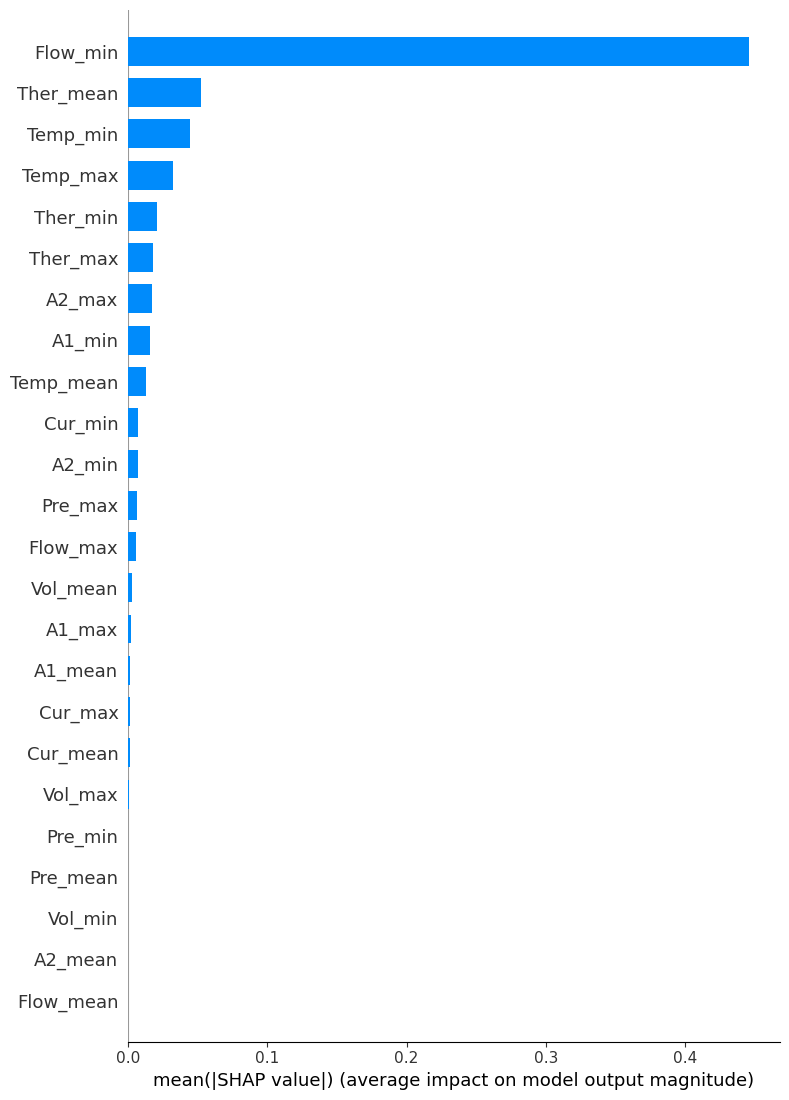

In [22]:
shap.summary_plot(shap_values[1], test_x, plot_type="bar", max_display=25)

In [23]:
pd.DataFrame(np.abs(shap_values[1]).mean(axis=0), index=train_x.columns).sort_values(by=0, ascending=False)

,0
Flow_min,0.445782
Ther_mean,0.052215
Temp_min,0.044218
Temp_max,0.031974
Ther_min,0.020672
Ther_max,0.017699
A2_max,0.017252
A1_min,0.015553
Temp_mean,0.012930
Cur_min,0.007048


In [24]:
from transformers.shap_feature_selector import SHAPFeatureSelector

In [79]:
shap_feature_selector = SHAPFeatureSelector(importance=0.8, estimator=model_lgb)

In [80]:
shap_feature_selector

SHAPFeatureSelector(estimator=<lightgbm.basic.Booster object at 0x16c01dd90>,
                    importance=0.8)

In [81]:
train_x_imp = shap_feature_selector.fit_transform(train_x)

In [82]:
train_x_imp.shape

(12703, 19)

In [83]:
train_x_imp.head()

,Vol_max,Cur_mean,Cur_max,A1_mean,A1_max,Vol_mean,Flow_max,Pre_max,A2_min,Cur_min,Temp_mean,A1_min,A2_max,Ther_max,Ther_min,Temp_max,Temp_min,Ther_mean,Flow_min
0,1.105874,1.183536,1.910003,-2.679089,-2.451050,-0.071078,0.484738,2.948339,-0.766579,0.717977,3.279428,-2.864603,-0.560769,2.037442,2.022494,3.28562,3.276067,2.030184,0.384955
1,1.020366,1.078818,1.744711,-2.699031,-2.451050,-0.261791,0.493729,2.948339,-0.766579,0.717977,3.279551,-2.864603,-0.433684,2.037442,2.023645,3.28562,3.276067,2.031622,0.384955
2,0.779673,1.001878,1.618241,-2.707403,-2.510998,-0.414315,0.496849,2.809283,-0.766579,0.717977,3.279547,-2.864603,-0.314984,2.037442,2.024084,3.28562,3.276067,2.032984,0.384955
3,0.304761,0.955057,1.347916,-2.696253,-2.399500,-0.540164,0.542672,2.332220,-0.766579,0.717977,3.279478,-2.864603,-0.129719,2.037442,2.025584,3.28562,3.275564,2.034259,0.384955
4,-0.163899,0.933848,1.150024,-2.663400,-2.256516,-0.641341,0.553171,1.704836,-0.766579,0.717977,3.279439,-2.864603,-0.021372,2.037442,2.029125,3.28562,3.275564,2.035386,0.384955


In [84]:
valid_x_imp = shap_feature_selector.transform(valid_x)

In [85]:
valid_x_imp

,Vol_max,Cur_mean,Cur_max,A1_mean,A1_max,Vol_mean,Flow_max,Pre_max,A2_min,Cur_min,Temp_mean,A1_min,A2_max,Ther_max,Ther_min,Temp_max,Temp_min,Ther_mean,Flow_min
0,-0.118341,1.370564,1.756565,1.570403,1.734581,-0.581076,0.708621,-0.068977,-0.138708,0.797856,-1.650667,1.403408,0.307994,-1.208422,-1.215548,-1.635596,-1.665341,-1.210692,0.647898
1,-0.118341,1.262195,1.703048,1.587588,1.734581,-0.660966,0.729587,-0.068977,-0.138708,0.672868,-1.653437,1.457839,0.339733,-1.208518,-1.215548,-1.637977,-1.665341,-1.211386,0.647898
2,-0.118341,1.153335,1.615673,1.591639,1.734581,-0.739583,0.736887,-0.068977,-0.085803,0.614453,-1.656410,1.494163,0.345922,-1.208518,-1.216246,-1.642719,-1.667707,-1.212147,0.647898
3,-0.561576,1.039734,1.551977,1.584562,1.734581,-0.844146,0.736887,-0.068977,-0.009899,0.479665,-1.659287,1.439392,0.419858,-1.209517,-1.216246,-1.643703,-1.671498,-1.212880,0.647898
4,-0.575822,0.918418,1.476192,1.581250,1.734581,-0.904174,0.736887,-0.068977,0.064939,0.338817,-1.661740,1.439392,0.528363,-1.209763,-1.216246,-1.644844,-1.671498,-1.213515,0.647898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,-0.163787,-0.209142,-0.084001,0.605687,0.780575,-0.991494,0.496847,1.022474,-1.419498,-0.344857,-1.016762,0.292714,-0.802507,-1.760160,-1.768355,-0.991454,-1.034273,-1.765762,0.384955
3582,-0.408018,-0.183147,-0.084001,0.554110,0.780575,-1.125467,0.496847,1.022474,-1.651902,-0.264976,-1.021239,0.217532,-0.898795,-1.762796,-1.768355,-0.998178,-1.036221,-1.766276,0.386428
3583,-0.606447,-0.167847,-0.084001,0.492773,0.780575,-1.226430,0.496847,1.022474,-1.866947,-0.264976,-1.025182,0.133945,-0.983495,-1.762912,-1.768355,-1.004747,-1.037610,-1.766287,0.434660
3584,-0.890607,-0.161883,-0.084001,0.414324,0.738311,-1.332665,0.496847,1.022474,-2.150276,-0.264976,-1.028423,-0.003906,-1.058527,-1.759562,-1.768355,-1.011584,-1.037610,-1.765734,0.438866


In [86]:
test_x_imp = shap_feature_selector.transform(test_x)

## Training using 85% most impactful features

In [87]:
test_acc_imp,test_f1score_imp,test_cm_imp,test_pred_imp,model_lgb_imp, test_f_beta_score_imp=lgb_train_predict(train_x_imp,train_y,valid_x_imp,valid_y,test_x_imp,test_y,beta=2)

tn_imp, fp_imp, fn_imp, tp_imp = test_cm_imp.ravel()

recall_imp = tp_imp / (tp_imp + fn_imp)
precision_imp = tp_imp / (tp_imp + fp_imp)

print("**************************************")
print(f'TEST ACCURACY: {test_acc_imp:.3f}')
print(f'TEST PRECISION: {precision_imp:.3f}')
print(f'TEST RECALL: {recall_imp:.3f}')
print(f'TEST F1 SCORE: {test_f1score_imp:.3f}')
print(f'TEST FBETA SCORE: {test_f_beta_score_imp:.3f}')
print('TEST CONFUSION MATRIX:')
display(test_cm_imp)


[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
**************************************
TEST ACCURACY: 0.921
TEST PRECISION: 1.000
TEST RECALL: 0.819
TEST F1 SCORE: 0.901
TEST FBETA SCORE: 0.850
TEST CONFUSION MATRIX:


array([[1041,    0],
       [ 145,  658]])

# FURTHER IMPROVEMENT

## Using features that has an impact in correct direction (based on Correct and Incorrect direction and target value, calculate f_beta for each feature)

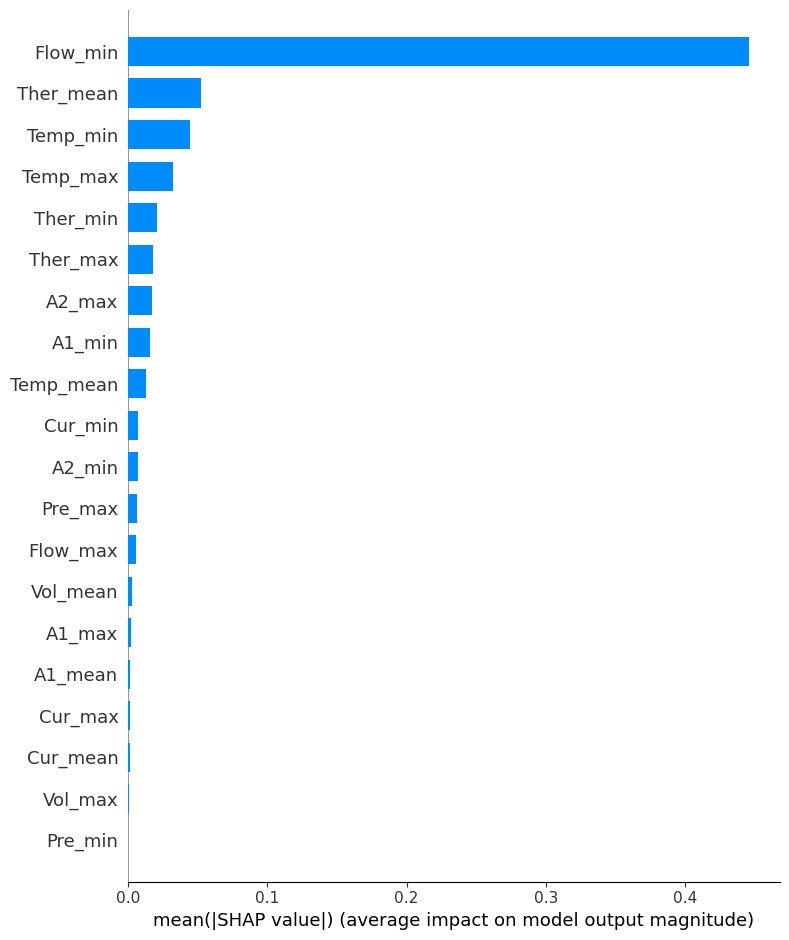

In [88]:
shap.summary_plot(shap_values[1], test_x, plot_type="bar")

In [89]:
pd.DataFrame(shap_values[1][100, :], index=train_x.columns).head(25)

,0
A1_mean,-0.000845
A1_min,-0.006380
A1_max,0.006181
A2_mean,0.000000
A2_min,0.001254
A2_max,0.000824
Cur_mean,0.000135
Cur_min,-0.013009
Cur_max,0.000368
Pre_mean,0.000000


In [90]:
# Non Anomaly Point
shap.force_plot(explainer.expected_value[1], shap_values[1][100, :], train_x.iloc[100, :])

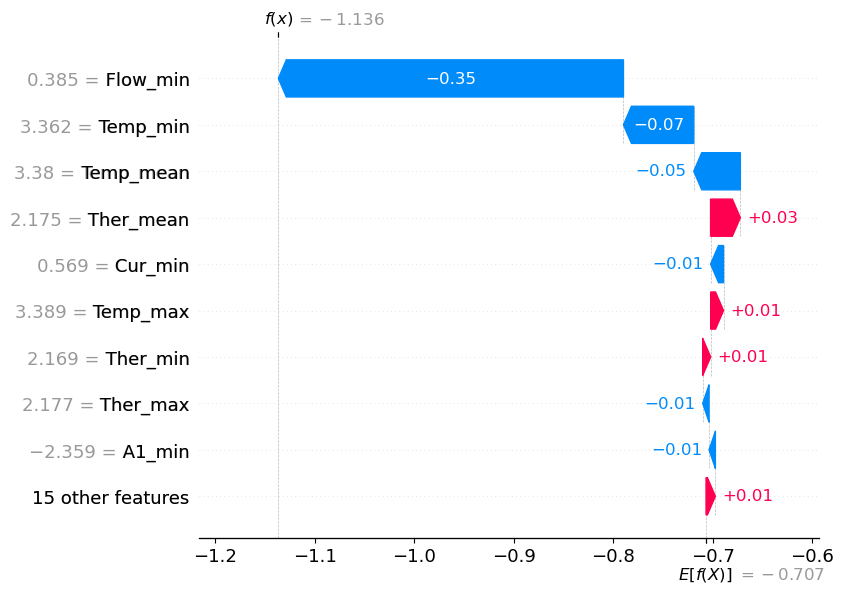

None

In [91]:
display(
    shap.waterfall_plot(shap.Explanation(values=shap_values[1][100], 
                                         base_values=explainer.expected_value[1], 
                                         data=train_x.iloc[100],  # added this line
                                         feature_names=train_x.columns.tolist())
                       )
)

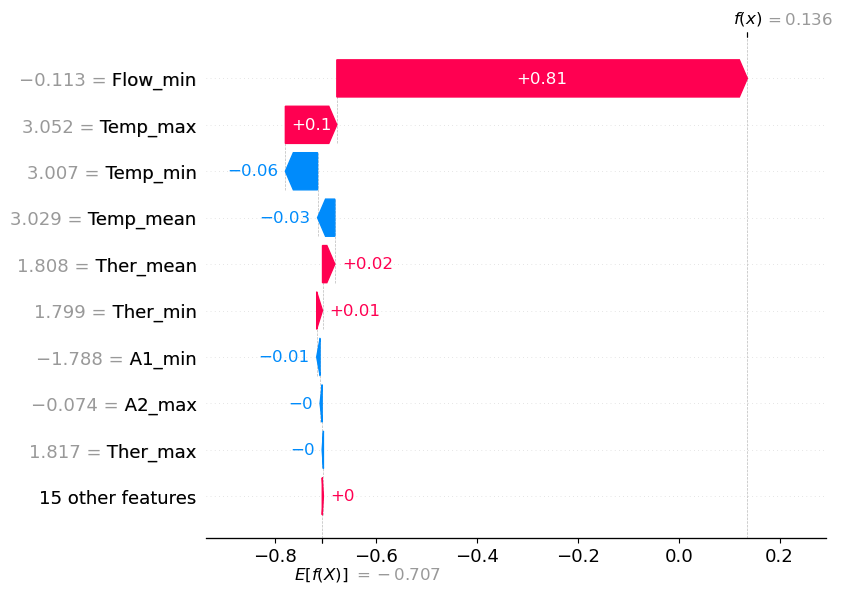

None

In [92]:
display(
    shap.waterfall_plot(shap.Explanation(values=shap_values[1][np.nonzero(train_y)[0][0], :], 
                                         base_values=explainer.expected_value[1], 
                                         data=train_x.iloc[np.nonzero(train_y)[0][0], :],  # added this line
                                         feature_names=train_x.columns.tolist())
                       )
)

In [39]:
# Non Anomaly Point
shap.force_plot(explainer.expected_value[1], shap_values[1][100, :], train_x.iloc[100, :], link='logit')

In [40]:
# Anomaly Point
shap.force_plot(explainer.expected_value[1], shap_values[1][np.nonzero(train_y)[0][0], :], train_x.iloc[np.nonzero(train_y)[0][0], :], link='logit')

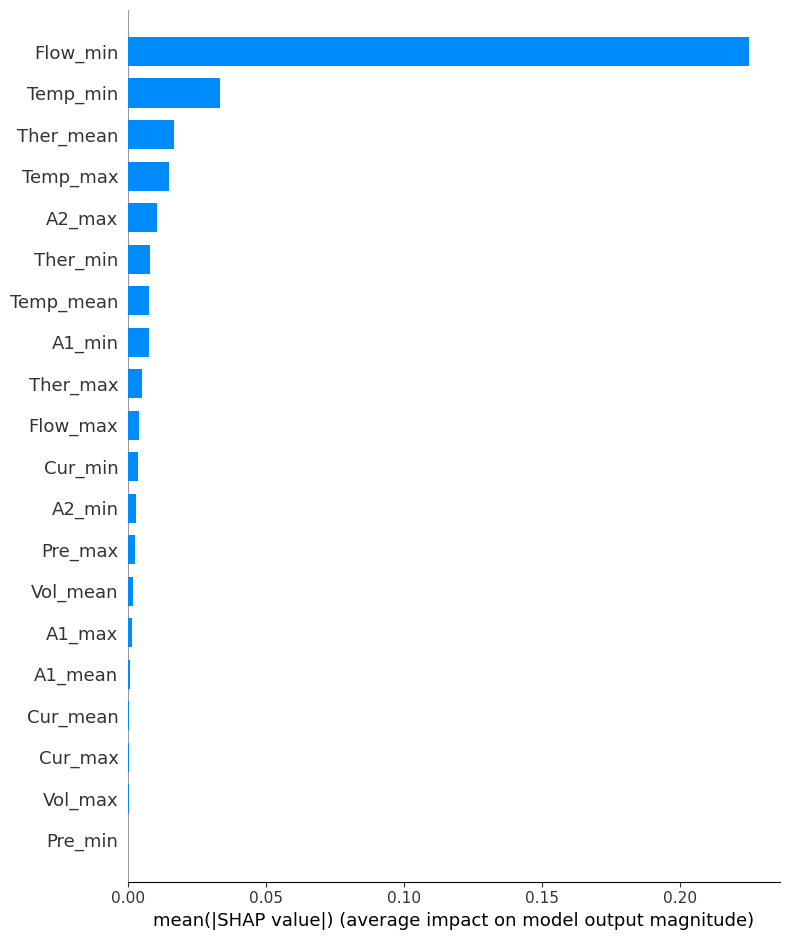

In [41]:
# TP impact
shap.summary_plot(shap_values[1].clip(min=0), train_x[train_y == 1], plot_type="bar")

In [93]:
shap_cm_df = shap_feature_selector.create_shap_cm_df(train_x, train_y, shap_values)
shap_cm_df.index = train_x.columns
shap_cm_df

,TP,FP,TN,FN
A1_mean,3471,6518,1876,838
A1_min,2341,3760,4634,1968
A1_max,450,903,7491,3859
A2_mean,0,0,0,0
A2_min,2605,5716,2678,1704
A2_max,2573,4523,3871,1736
Cur_mean,2765,5541,2853,1544
Cur_min,2954,5386,3008,1355
Cur_max,764,1415,6979,3545
Pre_mean,0,0,0,0


In [94]:
shap_cm_df['recall'], shap_cm_df['precision'], shap_cm_df['f_beta'], shap_cm_df['contrib_coef'], shap_cm_df['f_beta_score_normed'] = \
    (zip(*shap_cm_df.apply(lambda row: shap_feature_selector.get_f_beta_score(row['TP'], row['FP'], row['TN'], row['FN'], len(train_y), beta=2), axis=1)))

In [95]:
shap_cm_df

,TP,FP,TN,FN,recall,precision,f_beta,contrib_coef,f_beta_score_normed
A1_mean,3471,6518,1876,838,0.805523,0.347482,0.637466,1.0,0.637466
A1_min,2341,3760,4634,1968,0.543282,0.383708,0.501564,1.0,0.501564
A1_max,450,903,7491,3859,0.104433,0.332594,0.121039,1.0,0.121039
A2_mean,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000
A2_min,2605,5716,2678,1704,0.604549,0.313063,0.509645,1.0,0.509645
A2_max,2573,4523,3871,1736,0.597122,0.362599,0.528728,1.0,0.528728
Cur_mean,2765,5541,2853,1544,0.641680,0.332892,0.541265,1.0,0.541265
Cur_min,2954,5386,3008,1355,0.685542,0.354197,0.577495,1.0,0.577495
Cur_max,764,1415,6979,3545,0.177303,0.350620,0.196755,1.0,0.196755
Pre_mean,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000


In [96]:
shap_cm_df.sort_values(by='f_beta', ascending=False).head(25)

,TP,FP,TN,FN,recall,precision,f_beta,contrib_coef,f_beta_score_normed
Flow_min,3858,175,8219,451,0.895335,0.956608,0.906954,1.0,0.906954
Temp_mean,3759,6115,2279,550,0.872360,0.380697,0.693287,1.0,0.693287
Temp_min,3760,6286,2108,549,0.872592,0.374278,0.689099,1.0,0.689099
A1_mean,3471,6518,1876,838,0.805523,0.347482,0.637466,1.0,0.637466
Vol_mean,2970,5273,3121,1339,0.689255,0.360306,0.582833,1.0,0.582833
Cur_min,2954,5386,3008,1355,0.685542,0.354197,0.577495,1.0,0.577495
Cur_mean,2765,5541,2853,1544,0.641680,0.332892,0.541265,1.0,0.541265
A2_max,2573,4523,3871,1736,0.597122,0.362599,0.528728,1.0,0.528728
Ther_max,2447,4053,4341,1862,0.567881,0.376462,0.515462,1.0,0.515462
A2_min,2605,5716,2678,1704,0.604549,0.313063,0.509645,1.0,0.509645


In [109]:
shap_feature_selector_f_beta = SHAPFeatureSelector(importance=0.85, estimator=model_lgb, beta=2)

In [110]:
shap_feature_selector_f_beta

SHAPFeatureSelector(beta=2,
                    estimator=<lightgbm.basic.Booster object at 0x16c01dd90>)

In [111]:

train_x_imp_beta = shap_feature_selector_f_beta.fit_transform(train_x, train_y)

In [112]:
valid_x_imp_beta = shap_feature_selector_f_beta.transform(valid_x)

In [113]:
test_x_imp_beta = shap_feature_selector_f_beta.transform(test_x)

In [114]:
test_acc_imp_beta,test_f1score_imp_beta,test_cm_imp_beta,test_pred_imp_beta,model_lgb_imp_beta, test_f_beta_score_imp_beta=lgb_train_predict(train_x_imp_beta,train_y,valid_x_imp_beta,valid_y,test_x_imp_beta,test_y,beta=2)

tn_imp_beta, fp_imp_beta, fn_imp_beta, tp_imp_beta = test_cm_imp_beta.ravel()

recall_imp_beta = tp_imp_beta / (tp_imp_beta + fn_imp_beta)
precision_imp_beta = tp_imp_beta / (tp_imp_beta + fp_imp_beta)

print("**************************************")
print(f'TEST ACCURACY: {test_acc_imp_beta:.3f}')
print(f'TEST PRECISION: {precision_imp_beta:.3f}')
print(f'TEST RECALL: {recall_imp_beta:.3f}')
print(f'TEST F1 SCORE: {test_f1score_imp_beta:.3f}')
print(f'TEST FBETA SCORE: {test_f_beta_score_imp_beta:.3f}')
print('TEST CONFUSION MATRIX:')
display(test_cm_imp_beta)

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
**************************************
TEST ACCURACY: 0.925
TEST PRECISION: 1.000
TEST RECALL: 0.827
TEST F1 SCORE: 0.905
TEST FBETA SCORE: 0.857
TEST CONFUSION MATRIX:


array([[1041,    0],
       [ 139,  664]])

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

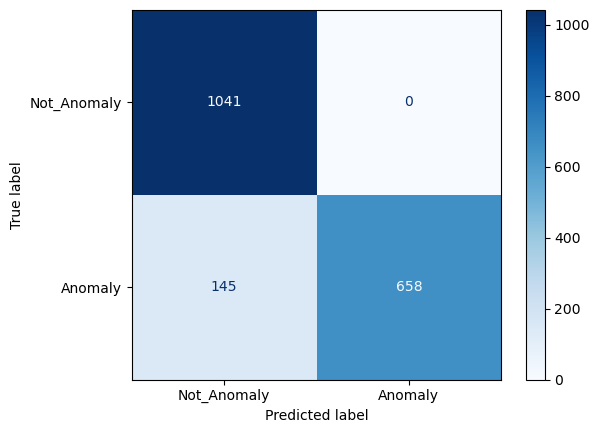

In [100]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Not_Anomaly', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

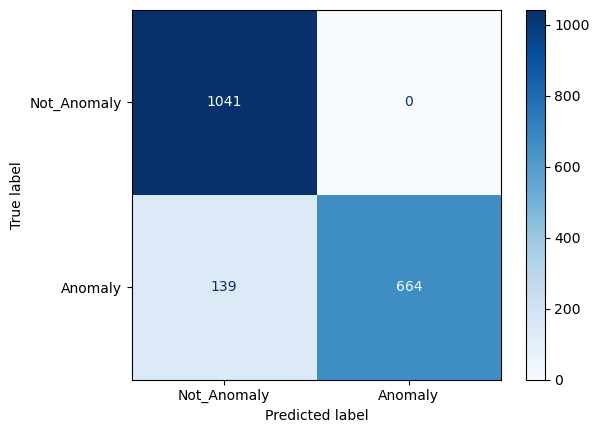

In [96]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_imp_beta, display_labels=['Not_Anomaly', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# OMNI XAI

In [ ]:
    #fine-tunned hyper paramters as found in baseline
    lgb_params = {
        'objective':'binary',
        'metric':'binary_error',
        'force_row_wise':True,
        'seed':0,
        'learning_rate':0.0424127,
        'min_data_in_leaf':15,
        'max_depth':24,
        'num_leaves':29
    }
    
    lgb_train=lgb.Dataset(x_train,y_train)
    lgb_valid=lgb.Dataset(x_valid,y_valid)
    lgb_test=lgb.Dataset(x_test,y_test)
    
    model_lgb=lgb.train(params=lgb_params,train_set=lgb_train, \
                        valid_sets=[lgb_train,lgb_valid], \
                        verbose_eval=0,early_stopping_rounds=20)

In [71]:
test_ac,test_f1sc,test_cm_,test_pre,model_lg, test_f_beta_sc=lgb_train_predict(x_train, y_train, x_valid, y_valid, x_test, y_test,beta=0.5)


print(f'TEST F1 SCORE: {test_f1sc:.3f}')
print(f'TEST FBETA SCORE: {test_f_beta_sc:.3f}')
print('TEST CONFUSION MATRIX:')
display(test_cm_)


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4309, number of negative: 8403
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 8
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338971 -> initscore=-0.667883
[LightGBM] [Info] Start training from score -0.667883
TEST F1 SCORE: 0.896
TEST FBETA SCORE: 0.938
TEST CONFUSION MATRIX:


array([[1028,   22],
       [ 133,  670]])

In [125]:
import omnixai

In [127]:
from omnixai.explainers import SHAPExplainer

ImportError: cannot import name 'SHAPExplainer' from 'omnixai.explainers' (/Users/gorelik/miniconda3/envs/mlops_fix/lib/python3.9/site-packages/omnixai/explainers/__init__.py)

In [126]:
explainer = omnixai.SHAPExplainer(model_lgb)

AttributeError: module 'omnixai' has no attribute 'SHAPExplainer'

In [64]:
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer

In [136]:
def predict_fn(x):
    # if isinstance(x, Timeseries):
    #     x = x.to_pd()
    anomaly_scores = model_lg.predict(x.values)
    print(anomaly_scores.shape)
    print(type(anomaly_scores))
    
    return anomaly_scores #(anomaly_scores > 0.5).astype(int)

In [66]:
x_train_omni = x_train.copy()

In [74]:
def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > 0.5).astype(int))
    return anomaly_scores / ts.shape[0]

In [73]:
x_train_omni

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
timestamp,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0000
2020-03-09 10:14:34,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0000
2020-03-09 10:14:35,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0000
2020-03-09 10:14:36,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0000
2020-03-09 10:14:37,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 13:59:09,0.028142,0.039445,0.981651,0.382638,66.9901,24.7381,232.774,32.0000
2020-03-09 13:59:10,0.028283,0.040615,0.966102,0.054711,66.8982,24.7404,227.030,32.0226
2020-03-09 13:59:11,0.028778,0.041955,0.827491,-0.601143,66.8706,24.7499,228.784,32.9781


In [67]:
x_train_omni.index.names = ['timestamp']

In [137]:
explainers = TimeseriesExplainer(
    explainers=["shap"],
    mode="anomaly_detection",
    data=Timeseries.from_pd(x_train_omni[:10000]),
    model=predict_fn,
    preprocess=None,
    postprocess=None
)

In [122]:
explainers

In [67]:
test_x

,A1_mean,A1_min,A1_max,A2_mean,A2_min,A2_max,Cur_mean,Cur_min,Cur_max,Pre_mean,...,Temp_max,Ther_mean,Ther_min,Ther_max,Vol_mean,Vol_min,Vol_max,Flow_mean,Flow_min,Flow_max
0,0.051600,-0.378375,0.574997,-1.361974,-2.128975,-0.809912,0.463603,0.207286,0.797031,0.248922,...,-1.005870,-1.765112,-1.767461,-1.762285,0.621834,-0.629836,1.626911,0.538125,0.384955,0.666354
1,-0.030184,-0.378375,0.496766,-1.512460,-2.314773,-0.855490,0.430880,0.207286,0.797031,-0.061313,...,-1.005870,-1.764840,-1.767414,-1.762285,0.390858,-0.717491,1.626911,0.509985,0.384955,0.659746
2,-0.094051,-0.378375,0.397665,-1.666669,-2.397577,-0.957886,0.394410,0.207286,0.660126,-0.317197,...,-1.005870,-1.764811,-1.767414,-1.762285,0.125208,-1.029592,1.251906,0.482653,0.384955,0.640552
3,-0.131753,-0.378375,0.267799,-1.809283,-2.397577,-1.086631,0.371160,0.207286,0.660126,-0.518191,...,-1.006089,-1.764895,-1.768248,-1.762285,-0.139896,-1.399126,0.990952,0.457446,0.384955,0.581710
4,-0.149154,-0.378375,0.093789,-1.937672,-2.397577,-1.237678,0.366910,0.207286,0.617621,-0.654661,...,-1.006089,-1.765119,-1.768621,-1.762285,-0.352253,-1.399126,0.850233,0.442999,0.384955,0.559987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,0.604958,0.538541,0.671134,0.422064,0.309524,0.571205,-1.431088,-1.756308,-0.761723,-0.104830,...,-1.111294,-1.979203,-1.984693,-1.969486,0.157707,-0.591353,0.727824,0.794597,0.688355,0.849990
1840,0.602093,0.538541,0.671134,0.414695,0.309524,0.571205,-1.507540,-1.756308,-0.975626,0.205674,...,-1.111294,-1.977590,-1.984693,-1.967955,0.250531,-0.452272,0.727824,0.782781,0.688355,0.843259
1841,0.593067,0.462452,0.671134,0.420802,0.309524,0.571205,-1.571616,-1.756308,-1.232279,0.425563,...,-1.111294,-1.975776,-1.983675,-1.966548,0.263585,-0.321732,0.727824,0.771986,0.688355,0.835189
1842,0.583487,0.442743,0.671134,0.411778,0.309524,0.546227,-1.606803,-1.756308,-1.409503,0.573982,...,-1.111294,-1.973831,-1.983038,-1.964224,0.217118,-0.515698,0.727824,0.760680,0.688355,0.826540


In [141]:
test_instances = Timeseries.from_pd(x_train_omni[10000:10002])

In [142]:
# test_instances = Timeseries.from_pd(x_train_omni.iloc[10000:10002])
local_explanations = explainers.explain(
    test_instances,
    params={"shap": {"nsamples": 5}}
)

(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'numpy.ndarray'>
(2,)
<class 'n

ValueError: Explainer shap -- operands could not be broadcast together with shapes (200,) (100,) 

In [82]:

local_explanations

OrderedDict([('predict',
              <omnixai.explanations.base.PredictedResults at 0x2a424d190>),
             ('shap',
              [{'instance':                       Current
              2020-03-09 13:11:54  1.299270
              2020-03-09 13:11:56  1.349470
              2020-03-09 13:11:57  1.160330
              2020-03-09 13:11:58  1.236460
              2020-03-09 13:11:59  1.177600
              ...                       ...
              2020-03-09 13:14:26  1.177780
              2020-03-09 13:14:27  0.574541
              2020-03-09 13:14:28  0.906512
              2020-03-09 13:14:29  0.840716
              2020-03-09 13:14:30  0.903720
              
              [150 rows x 1 columns], 'scores':                       Current  @timestamp
              2020-03-09 13:11:54  0.000400         0.0
              2020-03-09 13:11:56  0.000267         0.0
              2020-03-09 13:11:57  0.000267         0.0
              2020-03-09 13:11:58  0.000267         0.0
      

In [ ]:
train_x.shape

In [ ]:
model_lgb.predict(test_x)>=0.5,1,0

In [ ]:
model_lgb.predict(test_x)

In [ ]:
test_pred__=np.zeros((len(test_y),1))
test_pred__

In [ ]:
test_pred__[:,0]=np.where(model_lgb.predict(test_x)>=0.5,1,0)

In [ ]:
test_pred__

In [ ]:
np.where()